In [1]:
# import all libraries and modules needed
import os
import sys
import datetime
import glob
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

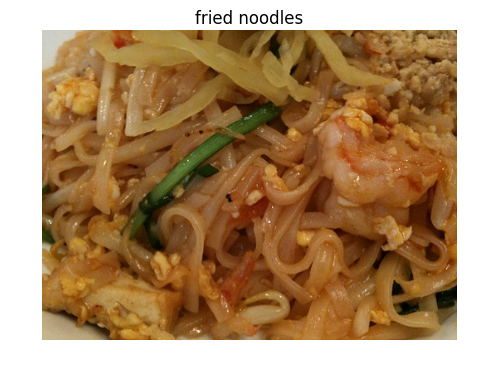

In [5]:
img = load_img('data/train/noodles_fried/4012787089_d1cca54838.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('fried noodles')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

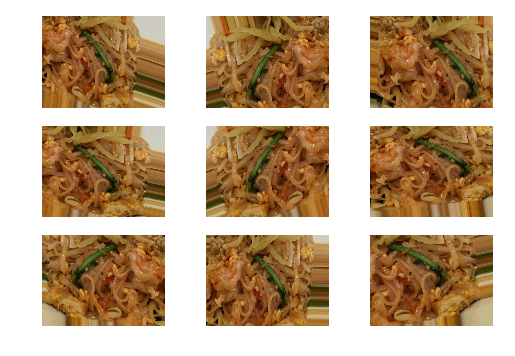

In [7]:
i = 0
fig = plt.figure()
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

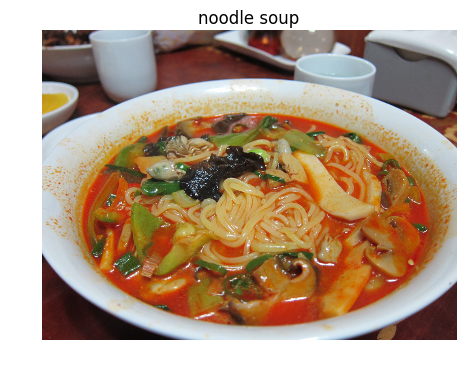

In [8]:
img = load_img('data/train/noodle_soup/5153183161_eb845fb8d9_b.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('noodle soup')
plt.show()

In [9]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [10]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

315


In [11]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

36


In [12]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# data pre-processing for validating
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [15]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [16]:
# set up transfer learning on pre-trained ImageNet Inception_V3 model - remove fully connected layer and replace
# with softmax for classifying 2 classes
incepV3_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape =(img_width, img_height, 3))
x = incepV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = incepV3_model.input, output = predictions)

In [17]:
# freeze all layers of the pre-trained model
for layer in incepV3_model.layers:
    layer.trainable = False

In [18]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
315/315 [==============================] - 158s - loss: 0.5098 - acc: 0.8254 - val_loss: 0.3289 - val_acc: 0.8889
Epoch 2/20
315/315 [==============================] - 152s - loss: 0.2497 - acc: 0.9175 - val_loss: 0.5510 - val_acc: 0.8611
Epoch 3/20
315/315 [==============================] - 149s - loss: 0.1684 - acc: 0.9302 - val_loss: 0.3829 - val_acc: 0.8611
Epoch 4/20
315/315 [==============================] - 149s - loss: 0.1705 - acc: 0.9333 - val_loss: 0.2949 - val_acc: 0.9444
Epoch 5/20
315/315 [==============================] - 147s - loss: 0.1367 - acc: 0.9619 - val_loss: 0.0986 - val_acc: 0.9444
Epoch 6/20
315/315 [==============================] - 147s - loss: 0.1393 - acc: 0.9460 - val_loss: 0.4950 - val_acc: 0.9167
Epoch 7/20
315/315 [==============================] - 147s - loss: 0.0794 - acc: 0.9778 - val_loss: 0.6138 - val_acc: 0.9167
Epoch 8/20
315/315 [==============================] - 148s - loss: 0.0940 - acc: 0.9714 - val_loss: 0.3934 - val_acc: 0.8889


In [20]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0015669928398
Test Accuracy: 1.0


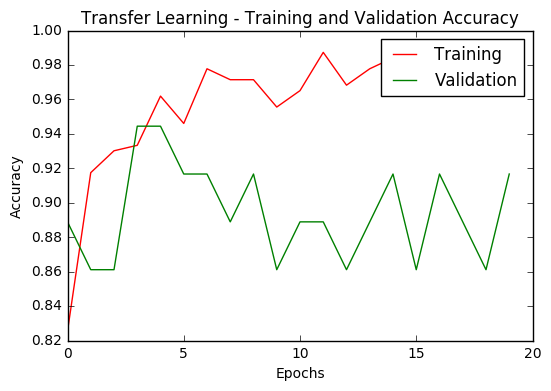

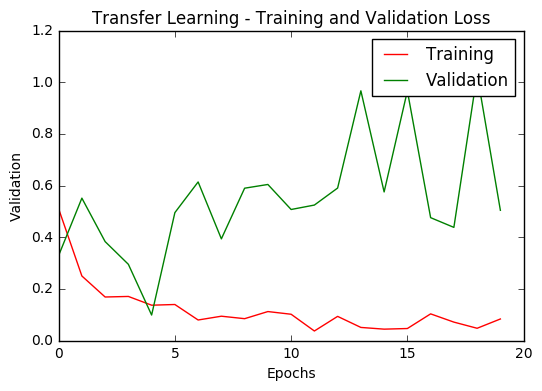

In [21]:
# plot the accuracy and loss data
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

plt.figure()
plt.plot(epochs, xfer_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, xfer_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation")
plt.legend()
plt.show()

In [22]:
# display the layers in the pretrained model
for i, layer in enumerate(incepV3_model.layers):
   print(i, layer.name)

0 input_1
1 convolution2d_1
2 batchnormalization_1
3 convolution2d_2
4 batchnormalization_2
5 convolution2d_3
6 batchnormalization_3
7 maxpooling2d_1
8 convolution2d_4
9 batchnormalization_4
10 convolution2d_5
11 batchnormalization_5
12 maxpooling2d_2
13 convolution2d_9
14 batchnormalization_9
15 convolution2d_7
16 convolution2d_10
17 batchnormalization_7
18 batchnormalization_10
19 averagepooling2d_1
20 convolution2d_6
21 convolution2d_8
22 convolution2d_11
23 convolution2d_12
24 batchnormalization_6
25 batchnormalization_8
26 batchnormalization_11
27 batchnormalization_12
28 mixed0
29 convolution2d_16
30 batchnormalization_16
31 convolution2d_14
32 convolution2d_17
33 batchnormalization_14
34 batchnormalization_17
35 averagepooling2d_2
36 convolution2d_13
37 convolution2d_15
38 convolution2d_18
39 convolution2d_19
40 batchnormalization_13
41 batchnormalization_15
42 batchnormalization_18
43 batchnormalization_19
44 mixed1
45 convolution2d_23
46 batchnormalization_23
47 convolution2d_

In [23]:
# display the details of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 149, 149, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 149, 149, 32)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 147, 147, 32)  9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [24]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Inception_V3 model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True

# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
315/315 [==============================] - 248s - loss: 0.0682 - acc: 0.9810 - val_loss: 0.8225 - val_acc: 0.8889
Epoch 2/20
315/315 [==============================] - 229s - loss: 0.0509 - acc: 0.9841 - val_loss: 0.8930 - val_acc: 0.8611
Epoch 3/20
315/315 [==============================] - 230s - loss: 0.0256 - acc: 0.9937 - val_loss: 0.7742 - val_acc: 0.8611
Epoch 4/20
315/315 [==============================] - 229s - loss: 0.0440 - acc: 0.9873 - val_loss: 0.5842 - val_acc: 0.9444
Epoch 5/20
315/315 [==============================] - 230s - loss: 0.0414 - acc: 0.9810 - val_loss: 0.7848 - val_acc: 0.8611
Epoch 6/20
315/315 [==============================] - 230s - loss: 0.0293 - acc: 0.9905 - val_loss: 0.8057 - val_acc: 0.8611
Epoch 7/20
315/315 [==============================] - 230s - loss: 0.0310 - acc: 0.9873 - val_loss: 0.7735 - val_acc: 0.9167
Epoch 8/20
315/315 [==============================] - 229s - loss: 0.0503 - acc: 0.9873 - val_loss: 0.6261 - val_acc: 0.8889


In [25]:
# evaluate the performance the revised model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.947747647762
Test Accuracy: 0.5


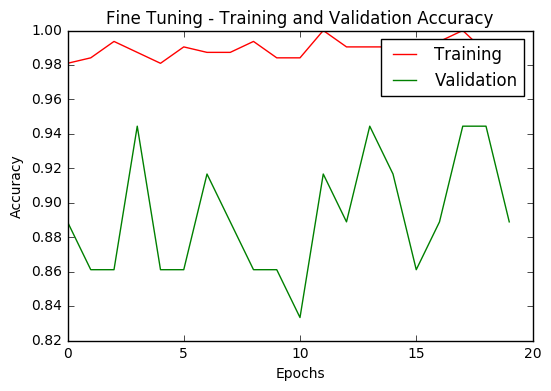

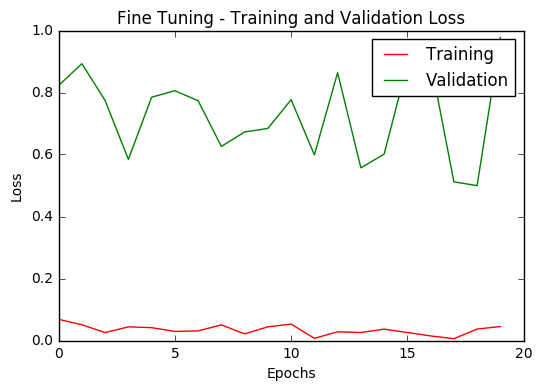

In [26]:
# plot the accuracy and loss data
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

plt.plot(epochs, ft_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, ft_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()